## This notebook takes Q and c (s::can) input from Hungerford and Wade catchments and runs a slightly modified version of Wang and Carey's 2017's HydRun workflow in R for automatic baseflow separation and event delineation

- Data from SV's email on 05.23.24 (`hb_q_chem copy.csv`, etc) copied to sonya-may24/ directory
- Data range 2021-2023 winters

Warning message in geom_line(data = hydrograph_separated$baseflow, aes(x = datetime, :
“Ignoring unknown parameters: `inewidth`”
Warning message:
“Removed 50974 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 50974 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 14641 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 50974 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 73 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 50974 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 50974 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 73 rows containing missing values (`geom_rect()`).”
Warning message:
“Removed 50974 rows containing missing values (`geom_line()`).”


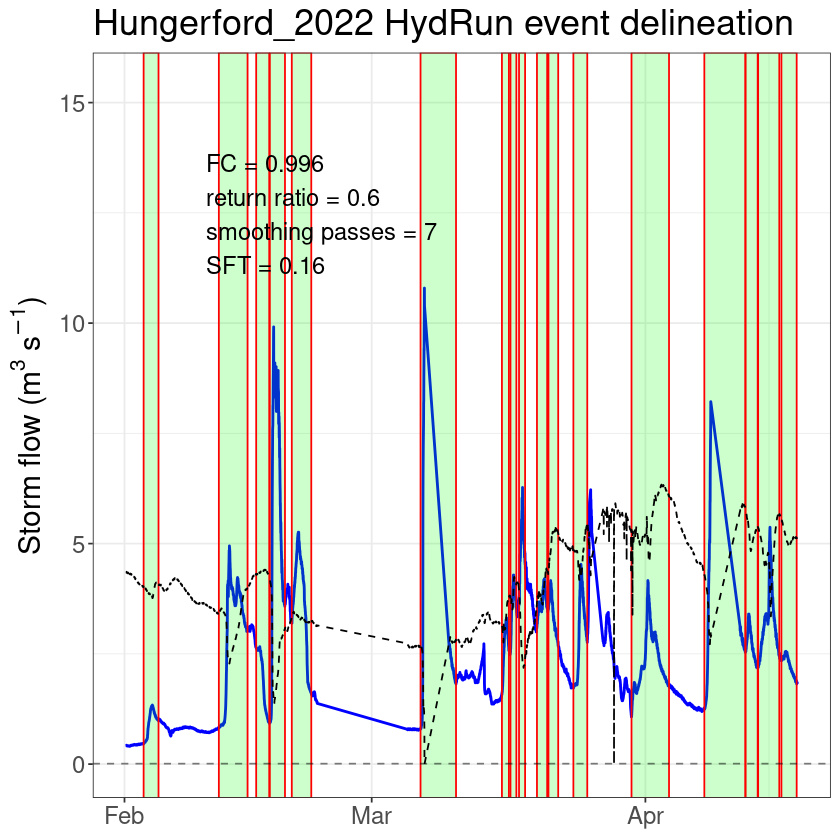

In [17]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(dplyr)
library(HydRun)

###################
# SET DIRECTORIES #
###################

input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data"
output_dir <- "~//OneDrive/git-repos/cQ_analysis/hydrun/output/newrnet"

################
# READ IN DATA #
################

# Downloaded on 05.27.24 from SV email
# Extact and rename the desired constituent as 'conc'
hydrograph <- read.csv(file.path(input_dir, "hb_q_chem copy.csv")) %>%
   mutate(datetime = ymd_hms(datetime)) %>%
   drop_na(q_cms_hb, NO3) %>% # drop NAs otherwise this will mess up rescale
   select(datetime, q_cms = q_cms_hb, conc = NO3) %>% 
   mutate(rescaled_conc = ((conc-min(conc))/(max(conc)-min(conc))*max(q_cms))) # rescale the data

# name the input data
dataSetName = "Hungerford_2022"

#######################
# BASEFLOW SEPARATION #
# + EVENT DELINEATION #
#######################

# Set RDF parameters
FC = 0.996
bf_passes = 3

# Set event extraction parameters
SFT = 0.16 # Dustin had 0.1 for Hford, 0.05 for Wade
return_ratio = 0.60 # Dustin had 0.1-0.18, I think should be higher for winter
beginning_slope = 0.75 # The beginning slope (slope threshold used to cut flat head)
end_slope = 0.75 # The ending slope (slope threshold to end event)
smoothing_passes = 7 # Dustin didn't specifiy - Millar used 4; should be higher for winter
minimum_duration = 100 # The minimum duration of a runoff event, expressed as the number of timesteps
dynamic_slope = 0.001 # The dynamic slope threshold used to cut the flat head and end the runoff event

# using 3 baseflow separation passes as in Millar example, also 0.996 as filter parameter as Kincaid 2020
hydrograph_separated <- separate.baseflow(hydrograph, filter = FC, passes = bf_passes)

# apply the runoff event extraction function
# this contains the same stormflow smoothing algorithm that the Millar code appropriates

# I'm using the defaults I can get from Kincaid 2020
runoff_events <- extract.runoff(hydrograph_separated$stormflow, 
                                min_diff = SFT, 
                                return_ratio = return_ratio, 
                                b_slope = beginning_slope, 
                                e_slope = end_slope, 
                                sc = smoothing_passes, # Millar example set to 4
                                min_dur = minimum_duration, # Dustin used 6 for Hford, 4 for Wade
                                dyslp = dynamic_slope)

#########################
# PLOT AND SAVE RESULTS #
#########################

# 1) Plot total discharge with baseflow

baseflowHydrograph <- ggplot() + 
    geom_line(data=hydrograph, aes(x=datetime, y=q_cms), 
        linewidth=0.5, color="black") +
    geom_line(data=hydrograph_separated$baseflow, aes(x=datetime, y=baseflow), 
        inewidth=0.75, color = "blue") +
    scale_color_brewer(palette = "Set1") +
    xlab(NULL) +
    ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
    scale_x_datetime(limits = as.POSIXct(c("2022-02-01 00:00:00", "2022-04-18 01:00:00"))) +
    theme_bw() +
    theme(legend.title = element_blank(),
    text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_Baseflows.jpeg")),
       baseflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 2) Plot stormflow

stormflowHydrograph <- ggplot() + 
  geom_line(data=hydrograph, aes(x=datetime, y=q_cms), 
        linewidth=0.5, color="black") +
  geom_line(data=hydrograph_separated$stormflow, aes(x=datetime, y=stormflow), 
        linewidth=0.75, color = "blue") +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnly.jpeg")),
       stormflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 3a) Plot smoothed storm flows with storm flow thresholds

# Combine all event dataframes into one
all_events <- do.call(rbind, lapply(names(runoff_events$RunoffEvents), function(event) {
  df <- runoff_events$RunoffEvents[[event]]
  df$event <- event
  df
}))

# Calculate the start and end times for each event
event_times <- all_events %>%
  group_by(event) %>%
  summarise(
    start = min(datetime),
    end = max(datetime),
    duration_hrs = (end - start) / 3600
  )

stormflowThreshHydrograph <- ggplot(all_events, aes(x = datetime, y = event_stormflow, color = "0.99")) + 
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = 0.01, linetype = "dashed", color = "black", alpha = 0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (", m^3, " ", s^-1, ")"))) +
  scale_x_datetime(limits = as.POSIXct(c("2022-02-01 00:00:00", "2022-04-18 01:00:00"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text = element_text(size = 18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnlyWithThresholds.jpeg")),
       stormflowThreshHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 4) Plot stormflow with shaded event durations

eventsDataShaded1 <- ggplot() + 
  geom_line(data=hydrograph, aes(x=datetime, y=q_cms), size=0.8, color="blue") +
  geom_rect(data = event_times, aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf), 
            fill = "green", color = 'red', alpha = 0.2, inherit.aes = FALSE) +
  geom_line(data=hydrograph, aes(x=datetime, y=rescaled_conc), size=0.5, color="black", linetype="dashed") +
  geom_line(linewidth = 0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = 0.01, linetype = "dashed", color = "black", alpha = 0.5) +
  xlab(NULL) +
  ggtitle(paste(dataSetName, "HydRun event delineation", sep = " ")) +
  ylab(expression(paste("Storm flow (", m^3, " ", s^-1, ")"))) +
  scale_x_datetime(limits = as.POSIXct(c("2022-02-01 00:00:00", "2022-04-18 01:00:00"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text = element_text(size = 18)) +
  # Add the first line of annotation text
  annotate("text", x = as.POSIXct("2022-02-10 00:00:00"), y = max(hydrograph$q_cms) * 0.9, 
           label = paste("FC = ", FC, sep = ""),
           hjust = 0, vjust = 1, size = 5, color = "black") +
  # Add the second line of annotation text
  annotate("text", x = as.POSIXct("2022-02-10 00:00:00"), y = max(hydrograph$q_cms) * 0.85, 
           label = paste("return ratio = ", 0.6, sep = ""), 
           hjust = 0, vjust = 1, size = 5, color = "black") +
  # Add the third line of annotation text
  annotate("text", x = as.POSIXct("2022-02-10 00:00:00"), y = max(hydrograph$q_cms) * 0.8, 
           label = paste("smoothing passes = ", smoothing_passes, sep = ""), 
           hjust = 0, vjust = 1, size = 5, color = "black") +
  # Add the fourth line of annotation text
  annotate("text", x = as.POSIXct("2022-02-10 00:00:00"), y = max(hydrograph$q_cms) * 0.75, 
           label = paste("SFT = ", SFT, sep = ""),
           hjust = 0, vjust = 1, size = 5, color = "black")

# Save the plot with annotation
ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_BatchEventSeparationPlot_Annotated.jpeg")),
       eventsDataShaded1,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

eventsDataShaded1

# Quick calc of baseflow averages

In [8]:
# Whole baseflow timeseries
print(paste("entire dataset = ", (mean(hydrograph_separated$baseflow$baseflow))))

# Define the datetime limits
limits <- as.POSIXct(c("2022-02-01 00:00:00", "2022-04-18 01:00:00"))

# Filter the dataframe to include only the rows within the specified datetime range
filtered_baseflow <- hydrograph_separated$baseflow %>%
  dplyr::filter(datetime >= limits[1] & datetime <= limits[2])

# Same filter for q
filtered_q <- hydrograph %>%
  dplyr::filter(datetime >= limits[1] & datetime <= limits[2])

# Calculate the mean of the baseflow column within the specified datetime range
mean_baseflow <- mean(filtered_baseflow$baseflow, na.rm = TRUE)

# Calculate the mean of the baseflow column within the specified datetime range
mean_q <- mean(filtered_q$q_cms, na.rm = TRUE)

print(paste("Winter 2022 baseflow = ", mean_baseflow))
print(paste("Winter 2022 discharge = ", mean_q))

[1] "entire dataset =  0.934625826619355"
[1] "Winter 2022 baseflow =  1.69720419367274"
[1] "Winter 2022 discharge =  2.62102491678216"
